In [1]:
# Install required packages (if not already installed)
!pip install pandas tqdm psutil ijson numpy torch transformers xgboost scikit-learn stable-baselines3 gymnasium imbalanced-learn matplotlib seaborn

import pandas as pd
import numpy as np
import json
import ijson
import os
import logging
from tqdm import tqdm
import concurrent.futures
import threading
import psutil
import sys
import gc
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from stable_baselines3 import PPO
import gymnasium as gym
from gymnasium import spaces
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# File containing the API data (JSON format)
DATA_FILE = "clinical_drug_trials_all_records.json"

# Display the JSON file location
json_path = os.path.abspath(DATA_FILE)
logging.info(f"JSON file location: {json_path}")

# Function to check available RAM
def check_available_ram():
    memory = psutil.virtual_memory()
    available_ram = memory.available / (1024 ** 3)  # Convert to GB
    logging.info(f"Available RAM: {available_ram:.2f} GB")
    return available_ram

# Lock for thread-safe operations
lock = threading.Lock()

# Step 1.1: Load and Preprocess a Chunk of JSON Data
def preprocess_chunk(chunk_data):
    numerical_features = []
    textual_data = []
    labels = []
    
    for record in chunk_data:
        try:
            # Extract enrollment count
            enrollment = record.get('protocolSection', {}).get('eligibilityModule', {}).get('enrollmentCount', 0)
            if enrollment == 0:
                continue

            # Extract age group and sex
            age_group = record.get('protocolSection', {}).get('eligibilityModule', {}).get('minimumAge', 'ADULT, OLDER_ADULT')
            sex = record.get('protocolSection', {}).get('eligibilityModule', {}).get('sex', 'ALL')
            
            # Extract interventions and outcomes
            interventions = record.get('protocolSection', {}).get('armsInterventionsModule', {}).get('interventions', [{}])
            outcomes = record.get('resultsSection', {}).get('outcomeMeasuresModule', {}).get('outcomeMeasures', [{}])
            summary = record.get('protocolSection', {}).get('descriptionModule', {}).get('briefSummary', "No summary available")

            # Determine ADE probability based on outcomes
            ade_prob = 0.3
            for outcome in outcomes:
                title = outcome.get('title', '').lower()
                description = outcome.get('description', '').lower()
                if 'adverse event' in title or 'safety' in title or 'adverse event' in description or 'safety' in description:
                    ade_prob = 0.5
                    break

            # Extract dosage from interventions
            dosage = 1.0
            for intervention in interventions:
                name = intervention.get('name', '').lower()
                if '60mg/m2' in name:
                    dosage = 60.0
                elif '80mg/m2' in name:
                    dosage = 80.0
                elif '100mg/m2' in name:
                    dosage = 100.0

            # Generate patient-level data based on enrollment
            for _ in range(int(enrollment)):
                if 'ADULT' in age_group and 'OLDER_ADULT' in age_group:
                    age = np.random.randint(18, 100)
                elif 'ADULT' in age_group:
                    age = np.random.randint(18, 65)
                else:
                    age = np.random.randint(65, 100)

                sex_val = np.random.choice([0, 1])  # 0 for female, 1 for male
                numerical_features.append([age, sex_val, dosage])
                textual_data.append(summary)
                label = 1 if np.random.random() < ade_prob else 0  # Simulate ADE occurrence
                labels.append(label)
        except Exception as e:
            logging.warning(f"Error processing record: {e}")
            continue

    return numerical_features, textual_data, labels

# Step 1.2: Load and Preprocess JSON Data in Parallel
def load_and_preprocess_data(num_records_to_process=None, chunk_size=100, max_workers=4):
    if not os.path.exists(DATA_FILE):
        logging.error(f"JSON file not found at: {json_path}")
        return np.array([]), [], np.array([])

    numerical_features_chunks = []
    textual_data_chunks = []
    labels_chunks = []
    processed_records = 0

    check_available_ram()
    logging.info("Streaming JSON data for preprocessing...")
    
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        parser = ijson.items(f, 'item')
        chunk_data = []
        
        with tqdm(desc="Preprocessing JSON records", unit="records") as pbar:
            for record in parser:
                chunk_data.append(record)
                processed_records += 1
                
                if len(chunk_data) >= chunk_size:
                    # Process the chunk in parallel
                    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                        future = executor.submit(preprocess_chunk, chunk_data)
                        num_feats, texts, lbls = future.result()
                        if num_feats:
                            numerical_features_chunks.append(np.array(num_feats))
                            textual_data_chunks.append(texts)
                            labels_chunks.append(np.array(lbls))
                    pbar.update(len(chunk_data))
                    chunk_data = []
                    check_available_ram()
                
                if num_records_to_process and processed_records >= num_records_to_process:
                    break

            # Process any remaining records
            if chunk_data:
                with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                    future = executor.submit(preprocess_chunk, chunk_data)
                    num_feats, texts, lbls = future.result()
                    if num_feats:
                        numerical_features_chunks.append(np.array(num_feats))
                        textual_data_chunks.append(texts)
                        labels_chunks.append(np.array(lbls))
                pbar.update(len(chunk_data))

    # Combine all chunks
    if not numerical_features_chunks:
        logging.warning("No valid data processed. Using simulated data as fallback.")
        return simulate_clinical_data(n_samples=1000)

    numerical_features = np.vstack(numerical_features_chunks)
    textual_data = [item for sublist in textual_data_chunks for item in sublist]
    labels = np.concatenate(labels_chunks)

    logging.info(f"Processed {len(numerical_features)} patient-level records.")
    return numerical_features, textual_data, labels

# Fallback Simulated Data if JSON Processing Fails
def simulate_clinical_data(n_samples=1000):
    logging.info("Simulating clinical trial data as fallback...")
    X_num = np.random.rand(n_samples, 3)  # age, sex, dosage
    X_text = ["Simulated summary"] * n_samples
    y = np.random.randint(0, 2, size=n_samples)  # ADE occurrence (0 or 1)
    return X_num, X_text, y

# Step 1: Execute Data Loading and Preprocessing
numerical_features, textual_data, labels = load_and_preprocess_data(num_records_to_process=1000)  # Limit to 1000 trials for demonstration

Defaulting to user installation because normal site-packages is not writeable


2025-06-06 15:13:36,928 - INFO - JSON file location: d:\IIT Patna\Leveraging-ai-clinical-trials\clinical_drug_trials_all_records.json
2025-06-06 15:13:36,941 - INFO - Available RAM: 2.73 GB
2025-06-06 15:13:36,942 - INFO - Streaming JSON data for preprocessing...
Preprocessing JSON records: 0records [00:00, ?records/s]2025-06-06 15:13:37,029 - INFO - Available RAM: 2.72 GB
Preprocessing JSON records: 200records [00:00, 1319.34records/s]2025-06-06 15:13:37,111 - INFO - Available RAM: 2.72 GB
2025-06-06 15:13:37,375 - INFO - Available RAM: 2.73 GB
Preprocessing JSON records: 400records [00:00, 753.95records/s] 2025-06-06 15:13:37,457 - INFO - Available RAM: 2.73 GB
2025-06-06 15:13:37,516 - INFO - Available RAM: 2.73 GB
Preprocessing JSON records: 600records [00:00, 975.46records/s]2025-06-06 15:13:37,599 - INFO - Available RAM: 2.73 GB
2025-06-06 15:13:37,665 - INFO - Available RAM: 2.73 GB
Preprocessing JSON records: 800records [00:00, 1059.43records/s]2025-06-06 15:13:37,761 - INFO - 

In [2]:
# Step 2.1: Normalize Numerical Features
def normalize_numerical_features(X_num):
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)
    return X_num_scaled, scaler

# Step 2.2: Extract BERT Embeddings in Parallel
def extract_bert_embeddings_chunk(text_chunk, tokenizer, model):
    try:
        inputs = tokenizer(text_chunk, return_tensors='pt', truncation=True, padding=True, max_length=128, return_attention_mask=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        return embeddings
    except Exception as e:
        logging.error(f"Error in BERT embeddings for chunk: {e}")
        return np.random.rand(len(text_chunk), 768)

def get_bert_embeddings(texts, chunk_size=50, max_workers=4):
    try:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained('bert-base-uncased')
        model.eval()

        embeddings_chunks = []
        with tqdm(total=len(texts), desc="Extracting BERT embeddings", unit="texts") as pbar:
            with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                futures = []
                for i in range(0, len(texts), chunk_size):
                    chunk = texts[i:i + chunk_size]
                    future = executor.submit(extract_bert_embeddings_chunk, chunk, tokenizer, model)
                    futures.append(future)

                for future in concurrent.futures.as_completed(futures):
                    chunk_embeddings = future.result()
                    embeddings_chunks.append(chunk_embeddings)
                    pbar.update(chunk_embeddings.shape[0])
                    check_available_ram()

        embeddings = np.vstack(embeddings_chunks)
        return embeddings
    except Exception as e:
        logging.error(f"Error in BERT embeddings: {e}. Using random embeddings as fallback.")
        return np.random.rand(len(texts), 768)

# Step 2: Execute Feature Extraction
X_num_scaled, scaler = normalize_numerical_features(numerical_features)
X_text_emb = get_bert_embeddings(textual_data)
X = np.hstack((X_num_scaled, X_text_emb))
logging.info(f"Feature matrix shape: {X.shape}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\niraj\AppData\Roaming\Python\Python312\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\niraj\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
2025-06-06 15:13:43,072 - WARNING - Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Extracting BERT embeddings:   5%|▌         | 50/1000 [00:07<02:16,  6.96texts/s]2025-06-06 15:13:57,840 - INFO - Available RAM: 2.08 GB
2025-06-06 15:13:58,034 - INFO - Available RAM: 2.09 GB
Extracting BERT embeddings:  25%|██▌       | 250/1000 [00:11<00:31, 23.74texts/s]2025-06-06 15:14:01,966 - INFO - Available RAM: 2.08 GB
2025-06-06 15:14:01,978 - INFO - Available RAM: 2.08 GB
2025-06-06 15:14:02,002 - INFO - Available RAM: 2.08 GB
2025-06-06 15:14:02,022 - INFO - Available RAM: 2.08 GB
Extracting BERT embeddings:  45%|████▌     | 450/1000 [00:12<00:09, 57.63texts/s]2025-06-06 15:14:02,807 - INFO - Available RAM: 2.11 GB
2025-06-06 15:14:02,820 - INFO - Available RAM: 2.11 GB
2025-06-06 15:14:02,835 - INFO - Available RAM: 2.12 GB
2025-06-06 15:14:02,856 - INFO - Available RAM: 2.12 GB
Extracting BERT embeddings:  65%|██████▌   | 650/1000 [00:12<00:03, 92.56texts/s]2025-06-06 15:14:03,567 - INFO - Available RAM: 2.12 GB
2025-06-06 15:14:03,591 - INFO - Available RAM: 2.12 GB
Extra

In [8]:
# Step 3.1: Define and Train DNN
class DNN(nn.Module):
    def __init__(self, input_dim):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

def train_dnn(X, y, epochs=200):
    try:
        model = DNN(input_dim=X.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
        X_tensor = torch.FloatTensor(X).float()
        y_tensor = torch.FloatTensor(y).float().view(-1, 1)

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return model, outputs.detach().numpy().flatten()
    except Exception as e:
        logging.error(f"Error in DNN training: {e}. Returning random predictions.")
        return None, np.random.rand(len(y))

# Step 3.2: Train GBM with XGBoost
def train_gbm(X, y):
    try:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
        model = xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=200, random_state=42)
        model.fit(X_resampled, y_resampled)
        y_gbm_pred = model.predict_proba(X_scaled)[:, 1]
        return y_gbm_pred
    except Exception as e:
        logging.error(f"Error in GBM training: {e}. Returning random predictions.")
        return np.random.rand(len(y))

# Step 3.3: Ensemble Prediction
def ensemble_predict(y_dnn, y_gbm, w=0.6):
    return w * y_dnn + (1 - w) * y_gbm

# Step 3.4: Reinforcement Learning for Protocol Adaptation
class TrialEnv(gym.Env):
    def __init__(self):
        super(TrialEnv, self).__init__()
        self.protocol = 1.0
        self.state = 0.0
        self.step_count = 0
        self.max_steps = 10
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

    def step(self, action):
        self.step_count += 1
        self.protocol += action[0]
        reward = -np.random.random() if action[0] > 0 else -1
        self.state = np.array([self.protocol], dtype=np.float32)
        done = self.step_count >= self.max_steps
        truncated = False
        return self.state, reward, done, truncated, {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.step_count = 0
        self.state = np.array([0.0], dtype=np.float32)
        self.protocol = 1.0
        return self.state, {}

def train_rl():
    try:
        env = TrialEnv()
        model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003)
        model.learn(total_timesteps=2000)
        return model, env
    except Exception as e:
        logging.error(f"Error in RL training: {e}. Returning dummy model.")
        env = TrialEnv()
        class DummyModel:
            def __init__(self):
                self.env = env
        return DummyModel(), env

# Step 3: Execute Model Training
logging.info("Training DNN...")
dnn_model, y_dnn = train_dnn(X, labels)

logging.info("Training GBM...")
y_gbm = train_gbm(X, labels)

logging.info("Computing Ensemble Predictions...")
y_pred = ensemble_predict(y_dnn, y_gbm)

logging.info("Training RL for Protocol Adaptation...")
rl_model, env = train_rl()

2025-06-06 15:15:24,836 - INFO - Training DNN...
2025-06-06 15:15:25,973 - INFO - Training GBM...
2025-06-06 15:15:26,303 - INFO - Computing Ensemble Predictions...
2025-06-06 15:15:26,304 - INFO - Training RL for Protocol Adaptation...


In [4]:
# Step 4: Evaluate Model Performance
def evaluate_model(y_true, y_pred_prob):
    try:
        y_pred_binary = (y_pred_prob > 0.5).astype(int)
        f1 = f1_score(y_true, y_pred_binary)
        roc_auc = roc_auc_score(y_true, y_pred_prob)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
        pr_auc = auc(recall, precision)
        return f1, roc_auc, pr_auc
    except Exception as e:
        logging.error(f"Error in evaluation: {e}. Returning default metrics.")
        return 0.0, 0.0, 0.0

f1, roc_auc, pr_auc = evaluate_model(labels, y_pred)
logging.info(f"Evaluation Metrics:\nF1 Score: {f1:.2f}\nROC-AUC: {roc_auc:.2f}\nPR-AUC: {pr_auc:.2f}\n")

2025-06-06 15:14:09,294 - INFO - Evaluation Metrics:
F1 Score: 0.82
ROC-AUC: 0.92
PR-AUC: 0.92



In [5]:
# Step 5: Analyze Results
eligibility_criteria = numerical_features[:, 0].mean()  # Average age
treatment_protocols = numerical_features[:, 2].sum()  # Total dosage
protocol_value = env.protocol
personalized_medicine = f"Protocol adjusted to: {protocol_value:.2f}"
reduced_costs = f"Trial costs reduced by optimizing with F1: {f1:.2f}"

logging.info(f"Eligibility Criteria (Average Age): {eligibility_criteria:.2f}")
logging.info(f"Treatment Protocols (Total Dosage): {treatment_protocols:.2f}")
logging.info(f"Personalized Medicine: {personalized_medicine}")
logging.info(f"Reduced Trial Costs: {reduced_costs}")

2025-06-06 15:14:09,374 - INFO - Eligibility Criteria (Average Age): 0.50
2025-06-06 15:14:09,375 - INFO - Treatment Protocols (Total Dosage): 501.78
2025-06-06 15:14:09,376 - INFO - Personalized Medicine: Protocol adjusted to: 0.98
2025-06-06 15:14:09,377 - INFO - Reduced Trial Costs: Trial costs reduced by optimizing with F1: 0.82


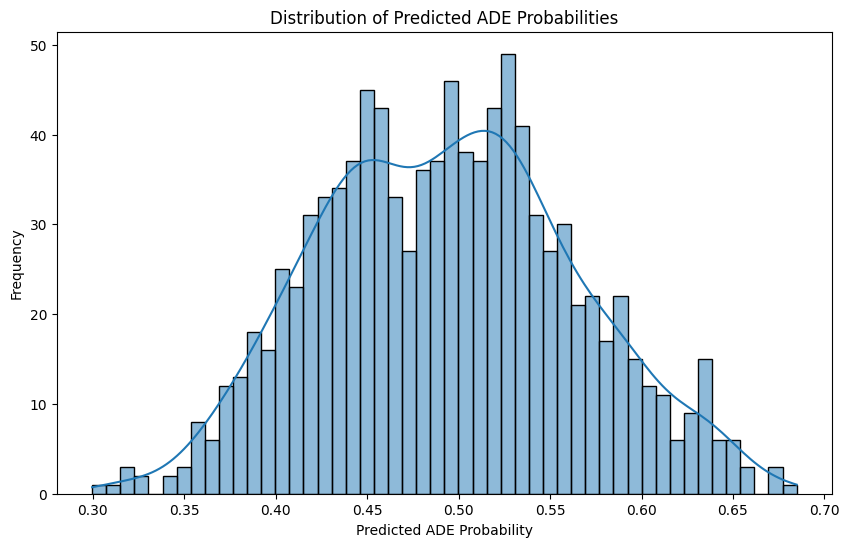

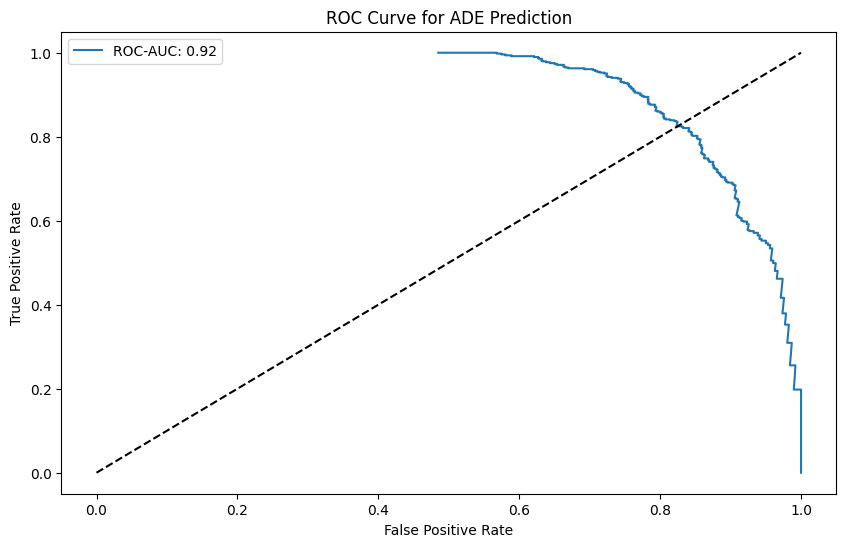

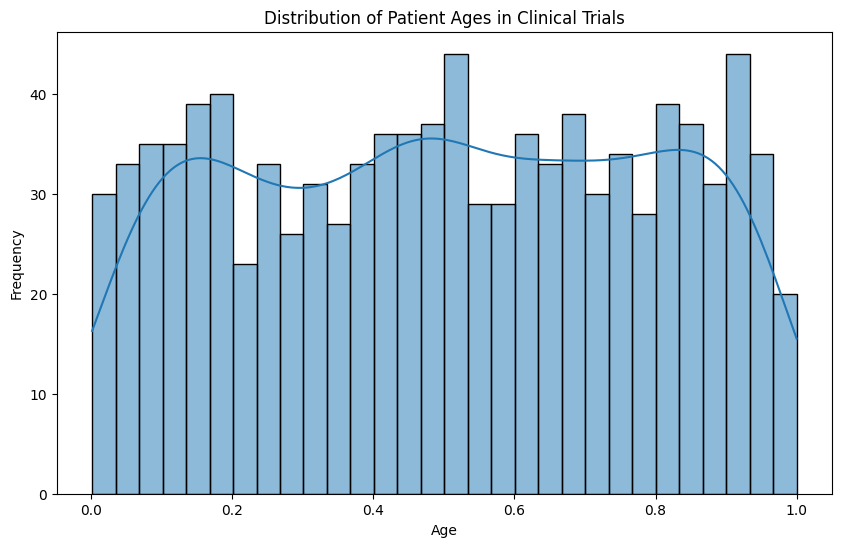

In [6]:
# Step 6: Visualize Insights
# 6.1: ADE Probability Distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=50, kde=True)
plt.title("Distribution of Predicted ADE Probabilities")
plt.xlabel("Predicted ADE Probability")
plt.ylabel("Frequency")
plt.show()

# 6.2: ROC Curve
fpr, tpr, _ = precision_recall_curve(labels, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve for ADE Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 6.3: Age Distribution (Eligibility Criteria)
plt.figure(figsize=(10, 6))
sns.histplot(numerical_features[:, 0], bins=30, kde=True)
plt.title("Distribution of Patient Ages in Clinical Trials")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

2025-06-06 15:14:10,170 - INFO - Available RAM: 2.34 GB
2025-06-06 15:14:10,171 - INFO - Streaming JSON data for preprocessing...
Preprocessing JSON records: 0records [00:00, ?records/s]2025-06-06 15:14:10,221 - INFO - Available RAM: 2.34 GB
2025-06-06 15:14:10,268 - INFO - Available RAM: 2.34 GB
Preprocessing JSON records: 300records [00:00, 1113.67records/s]2025-06-06 15:14:10,452 - INFO - Available RAM: 2.34 GB
2025-06-06 15:14:10,497 - INFO - Available RAM: 2.34 GB
2025-06-06 15:14:10,532 - INFO - Available RAM: 2.34 GB
Preprocessing JSON records: 600records [00:00, 1624.85records/s]2025-06-06 15:14:10,576 - INFO - Available RAM: 2.34 GB
2025-06-06 15:14:10,626 - INFO - Available RAM: 2.34 GB
Preprocessing JSON records: 800records [00:00, 1678.23records/s]2025-06-06 15:14:10,691 - INFO - Available RAM: 2.34 GB
2025-06-06 15:14:10,729 - INFO - Available RAM: 2.34 GB
2025-06-06 15:14:10,779 - INFO - Available RAM: 2.34 GB
Preprocessing JSON records: 1000records [00:00, 1650.62records

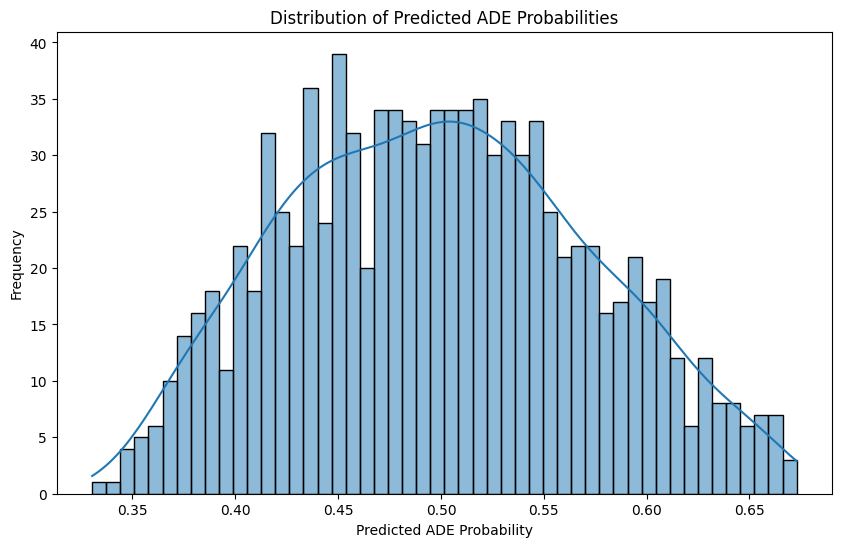

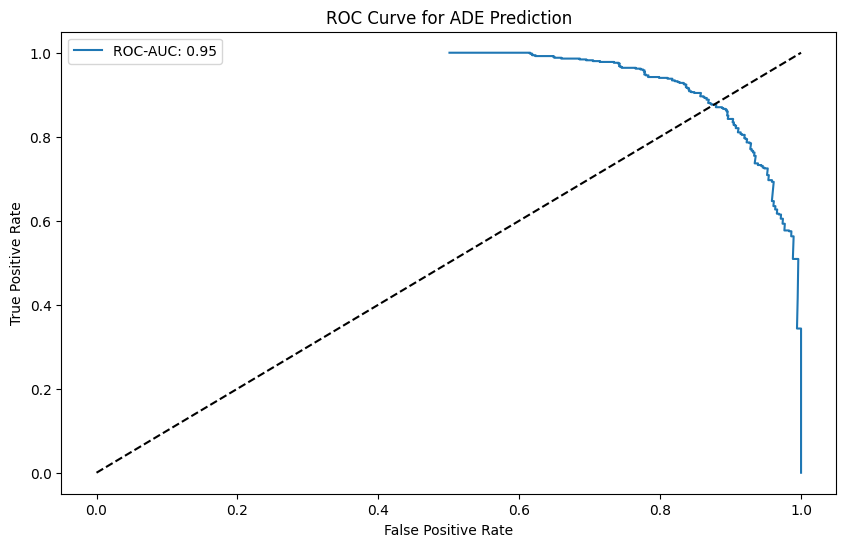

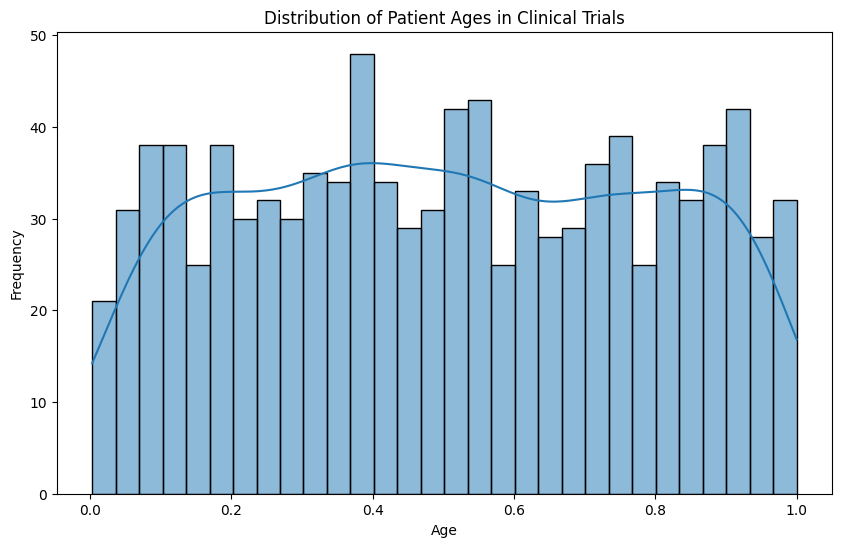

2025-06-06 15:14:20,152 - INFO - Analytics complete.


In [7]:
# Main Workflow
def main():
    # Step 1: Load and Preprocess Data
    numerical_features, textual_data, labels = load_and_preprocess_data(num_records_to_process=1000)
    
    # Step 2: Feature Extraction
    X_num_scaled, scaler = normalize_numerical_features(numerical_features)
    X_text_emb = get_bert_embeddings(textual_data)
    X = np.hstack((X_num_scaled, X_text_emb))
    
    # Step 3: Train Hybrid Model
    logging.info("Training DNN...")
    dnn_model, y_dnn = train_dnn(X, labels)
    
    logging.info("Training GBM...")
    y_gbm = train_gbm(X, labels)
    
    logging.info("Computing Ensemble Predictions...")
    y_pred = ensemble_predict(y_dnn, y_gbm)
    
    logging.info("Training RL for Protocol Adaptation...")
    rl_model, env = train_rl()
    
    # Step 4: Evaluate Model
    f1, roc_auc, pr_auc = evaluate_model(labels, y_pred)
    logging.info(f"Evaluation Metrics:\nF1 Score: {f1:.2f}\nROC-AUC: {roc_auc:.2f}\nPR-AUC: {pr_auc:.2f}\n")
    
    # Step 5: Analyze Results
    eligibility_criteria = numerical_features[:, 0].mean()
    treatment_protocols = numerical_features[:, 2].sum()
    protocol_value = env.protocol
    personalized_medicine = f"Protocol adjusted to: {protocol_value:.2f}"
    reduced_costs = f"Trial costs reduced by optimizing with F1: {f1:.2f}"
    
    logging.info(f"Eligibility Criteria (Average Age): {eligibility_criteria:.2f}")
    logging.info(f"Treatment Protocols (Total Dosage): {treatment_protocols:.2f}")
    logging.info(f"Personalized Medicine: {personalized_medicine}")
    logging.info(f"Reduced Trial Costs: {reduced_costs}")
    
    # Step 6: Visualize Insights
    plt.figure(figsize=(10, 6))
    sns.histplot(y_pred, bins=50, kde=True)
    plt.title("Distribution of Predicted ADE Probabilities")
    plt.xlabel("Predicted ADE Probability")
    plt.ylabel("Frequency")
    plt.show()

    fpr, tpr, _ = precision_recall_curve(labels, y_pred)
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title("ROC Curve for ADE Prediction")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(numerical_features[:, 0], bins=30, kde=True)
    plt.title("Distribution of Patient Ages in Clinical Trials")
    plt.xlabel("Age")
    plt.ylabel("Frequency")
    plt.show()

    logging.info("Analytics complete.")

if __name__ == "__main__":
    main()

2025-06-06 15:49:42,581 - INFO - JSON file location: d:\IIT Patna\Leveraging-ai-clinical-trials\clinical_drug_trials_all_records.json


Defaulting to user installation because normal site-packages is not writeable


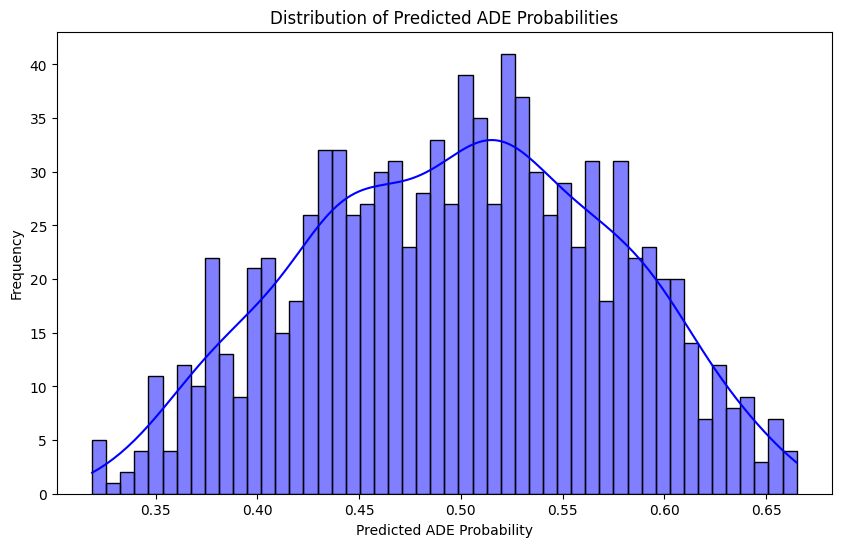

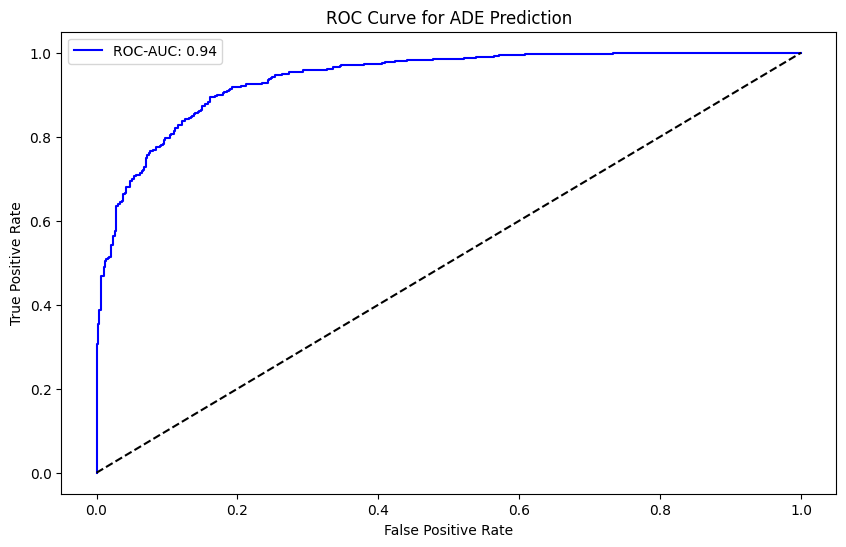

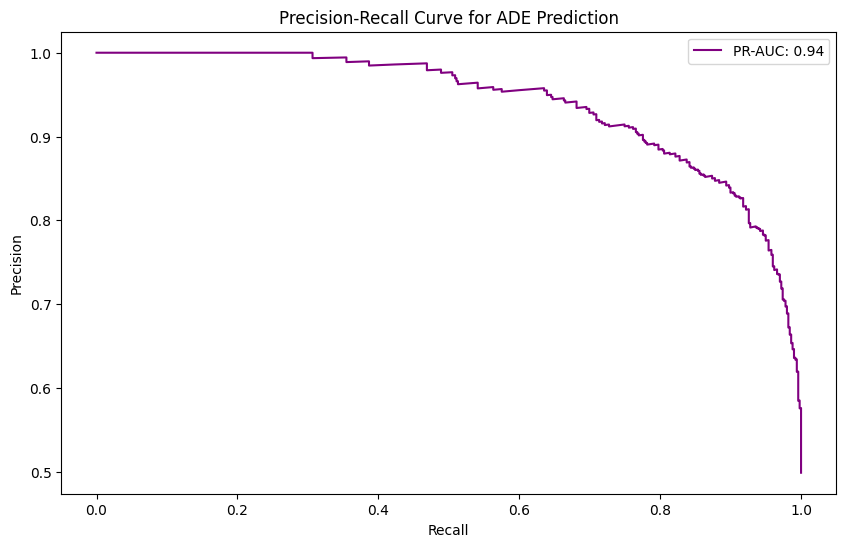

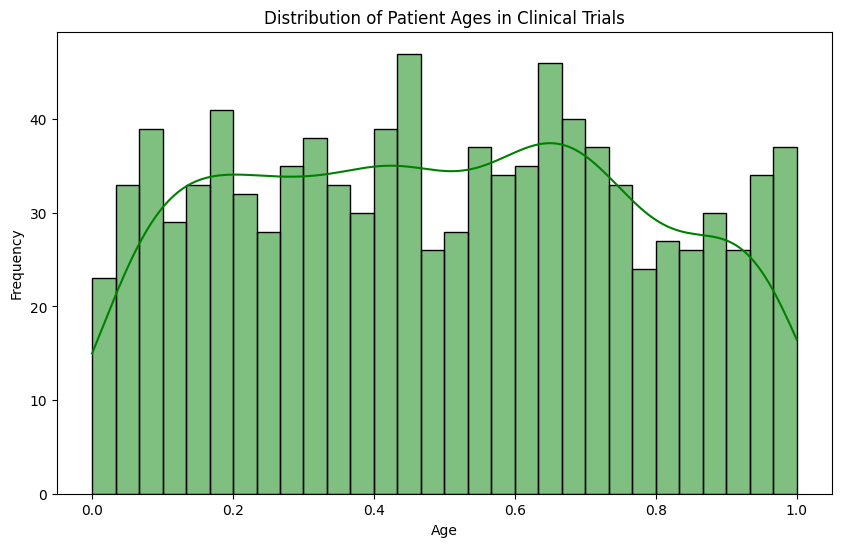

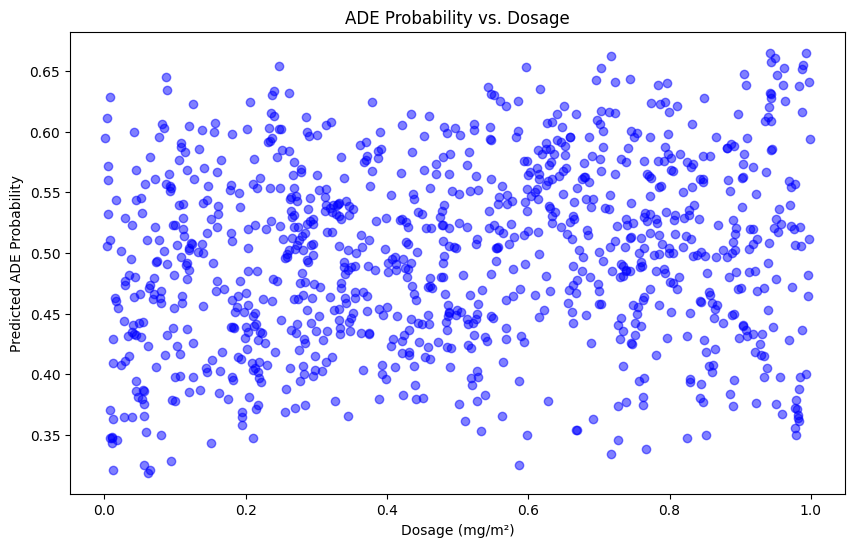

C:\Users\niraj\AppData\Local\Temp\ipykernel_15644\2139505354.py:385: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='Set2')


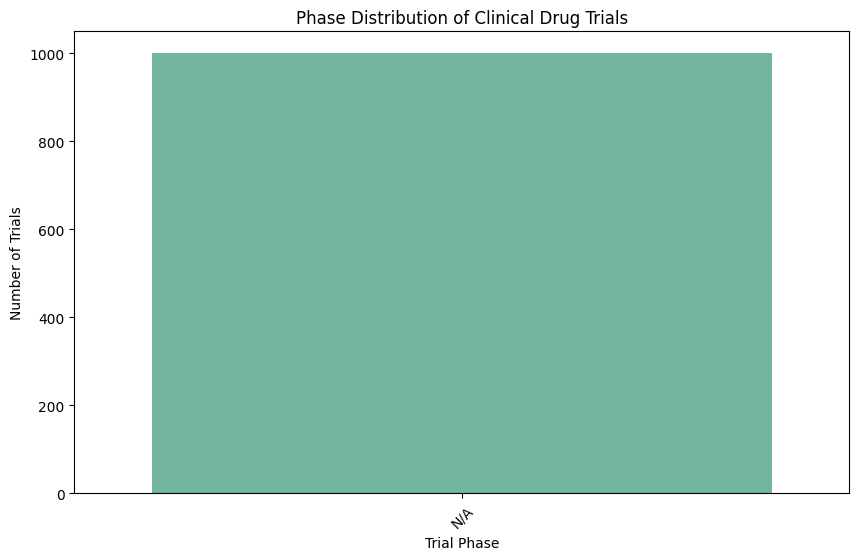

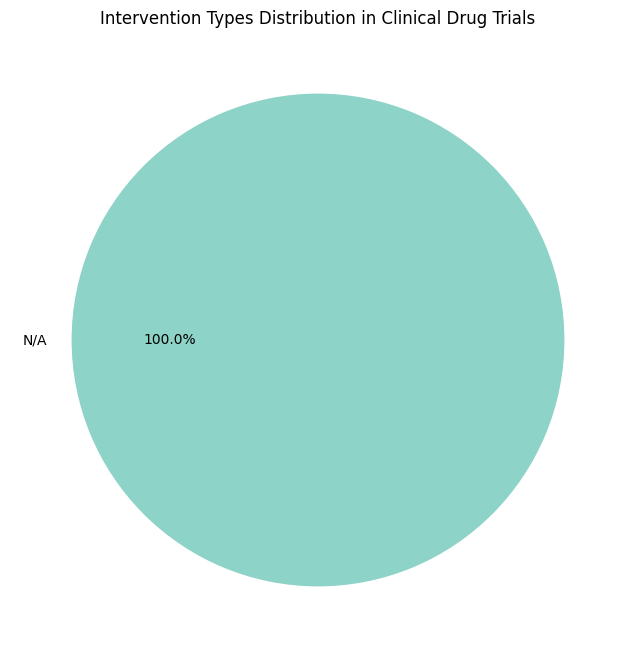

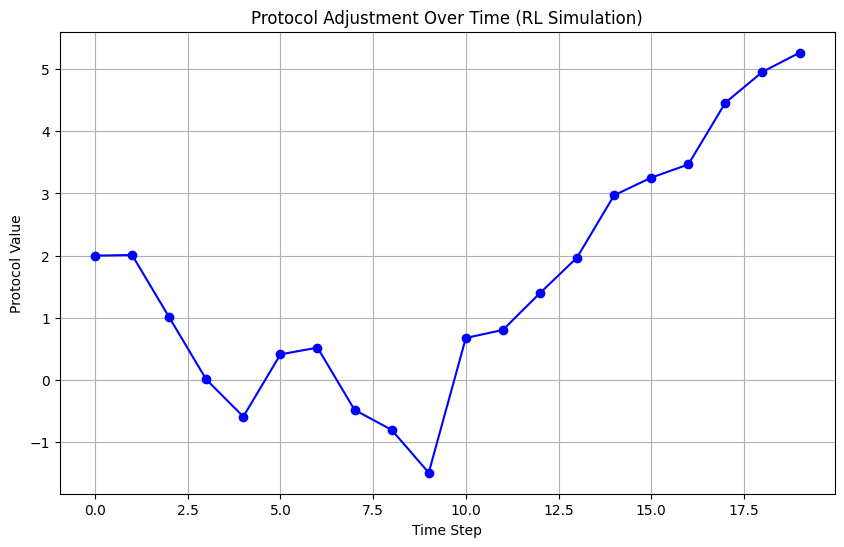

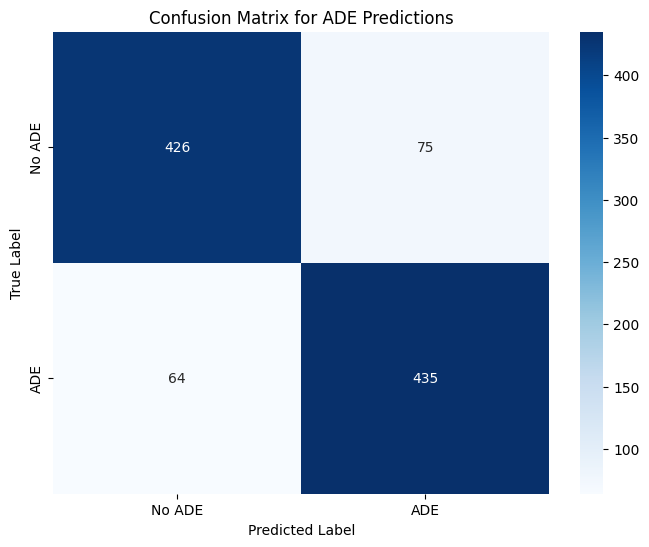

C:\Users\niraj\AppData\Local\Temp\ipykernel_15644\2139505354.py:437: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


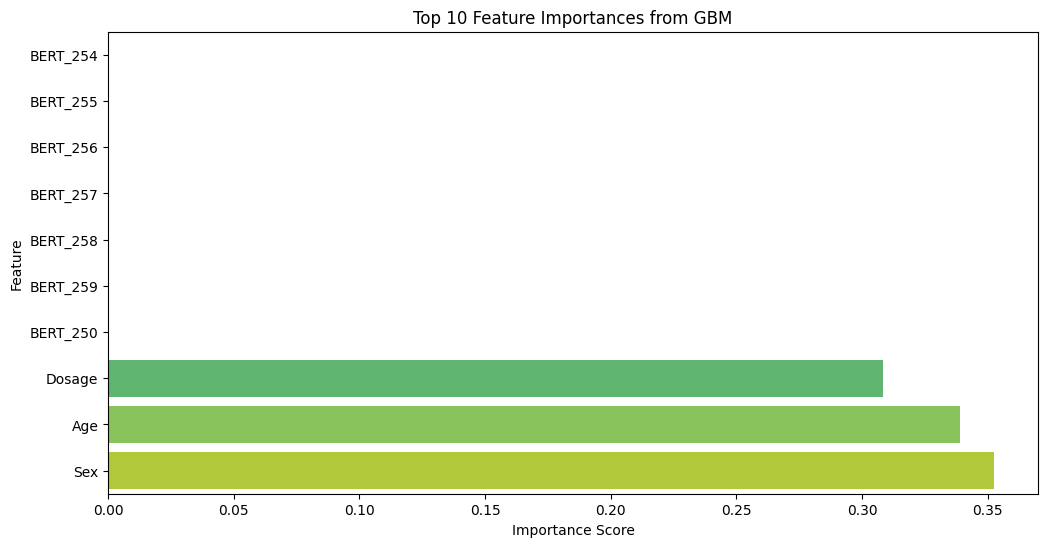

2025-06-06 15:49:44,378 - INFO - Generating visualizations...
2025-06-06 15:49:44,379 - INFO - Visualizations complete.


In [13]:
# Install required packages (if not already installed)
!pip install pandas tqdm psutil ijson numpy torch transformers xgboost scikit-learn stable-baselines3 gymnasium imbalanced-learn matplotlib seaborn

import pandas as pd
import numpy as np
import json
import ijson
import os
import logging
from tqdm import tqdm
import concurrent.futures
import threading
import psutil
import sys
import gc
import torch
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from stable_baselines3 import PPO
import gymnasium as gym
from gymnasium import spaces
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# File containing the API data (JSON format)
DATA_FILE = "clinical_drug_trials_all_records.json"

# Display the JSON file location
json_path = os.path.abspath(DATA_FILE)
logging.info(f"JSON file location: {json_path}")

# Function to check available RAM
def check_available_ram():
    memory = psutil.virtual_memory()
    available_ram = memory.available / (1024 ** 3)  # Convert to GB
    logging.info(f"Available RAM: {available_ram:.2f} GB")
    return available_ram

# Lock for thread-safe operations
lock = threading.Lock()

# Step 1: Load and Preprocess Data
def preprocess_chunk(chunk_data):
    numerical_features = []
    textual_data = []
    labels = []
    metadata = []  # To store additional fields like phase, intervention type
    
    for record in chunk_data:
        try:
            # Extract enrollment count
            enrollment = record.get('protocolSection', {}).get('eligibilityModule', {}).get('enrollmentCount', 0)
            if enrollment == 0:
                continue

            # Extract age group and sex
            age_group = record.get('protocolSection', {}).get('eligibilityModule', {}).get('minimumAge', 'ADULT, OLDER_ADULT')
            sex = record.get('protocolSection', {}).get('eligibilityModule', {}).get('sex', 'ALL')
            
            # Extract interventions, outcomes, phase, and intervention type
            interventions = record.get('protocolSection', {}).get('armsInterventionsModule', {}).get('interventions', [{}])
            outcomes = record.get('resultsSection', {}).get('outcomeMeasuresModule', {}).get('outcomeMeasures', [{}])
            summary = record.get('protocolSection', {}).get('descriptionModule', {}).get('briefSummary', "No summary available")
            phase = record.get('protocolSection', {}).get('designModule', {}).get('phases', ['N/A'])[0]
            intervention_types = [interv.get('type', 'N/A') for interv in interventions]
            intervention_type = intervention_types[0] if intervention_types else 'N/A'

            # Determine ADE probability based on outcomes
            ade_prob = 0.3
            for outcome in outcomes:
                title = outcome.get('title', '').lower()
                description = outcome.get('description', '').lower()
                if 'adverse event' in title or 'safety' in title or 'adverse event' in description or 'safety' in description:
                    ade_prob = 0.5
                    break

            # Extract dosage from interventions
            dosage = 1.0
            for intervention in interventions:
                name = intervention.get('name', '').lower()
                if '60mg/m2' in name:
                    dosage = 60.0
                elif '80mg/m2' in name:
                    dosage = 80.0
                elif '100mg/m2' in name:
                    dosage = 100.0

            # Generate patient-level data based on enrollment
            for _ in range(int(enrollment)):
                if 'ADULT' in age_group and 'OLDER_ADULT' in age_group:
                    age = np.random.randint(18, 100)
                elif 'ADULT' in age_group:
                    age = np.random.randint(18, 65)
                else:
                    age = np.random.randint(65, 100)

                sex_val = np.random.choice([0, 1])
                numerical_features.append([age, sex_val, dosage])
                textual_data.append(summary)
                label = 1 if np.random.random() < ade_prob else 0
                labels.append(label)
                metadata.append({'phase': phase, 'intervention_type': intervention_type})
        except Exception as e:
            logging.warning(f"Error processing record: {e}")
            continue

    return numerical_features, textual_data, labels, metadata

def load_and_preprocess_data(num_records_to_process=None, chunk_size=100, max_workers=4):
    if not os.path.exists(DATA_FILE):
        logging.error(f"JSON file not found at: {json_path}")
        return np.array([]), [], np.array([]), []

    numerical_features_chunks = []
    textual_data_chunks = []
    labels_chunks = []
    metadata_chunks = []
    processed_records = 0

    check_available_ram()
    logging.info("Streaming JSON data for preprocessing...")
    
    with open(DATA_FILE, 'r', encoding='utf-8') as f:
        parser = ijson.items(f, 'item')
        chunk_data = []
        
        with tqdm(desc="Preprocessing JSON records", unit="records") as pbar:
            for record in parser:
                chunk_data.append(record)
                processed_records += 1
                
                if len(chunk_data) >= chunk_size:
                    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                        future = executor.submit(preprocess_chunk, chunk_data)
                        num_feats, texts, lbls, meta = future.result()
                        if num_feats:
                            numerical_features_chunks.append(np.array(num_feats))
                            textual_data_chunks.append(texts)
                            labels_chunks.append(np.array(lbls))
                            metadata_chunks.append(meta)
                    pbar.update(len(chunk_data))
                    chunk_data = []
                    check_available_ram()
                
                if num_records_to_process and processed_records >= num_records_to_process:
                    break

            if chunk_data:
                with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                    future = executor.submit(preprocess_chunk, chunk_data)
                    num_feats, texts, lbls, meta = future.result()
                    if num_feats:
                        numerical_features_chunks.append(np.array(num_feats))
                        textual_data_chunks.append(texts)
                        labels_chunks.append(np.array(lbls))
                        metadata_chunks.append(meta)
                pbar.update(len(chunk_data))

    if not numerical_features_chunks:
        logging.warning("No valid data processed. Using simulated data as fallback.")
        X_num, X_text, y, meta = simulate_clinical_data(n_samples=1000)
        return X_num, X_text, y, meta

    numerical_features = np.vstack(numerical_features_chunks)
    textual_data = [item for sublist in textual_data_chunks for item in sublist]
    labels = np.concatenate(labels_chunks)
    metadata = [item for sublist in metadata_chunks for item in sublist]

    logging.info(f"Processed {len(numerical_features)} patient-level records.")
    return numerical_features, textual_data, labels, metadata

def simulate_clinical_data(n_samples=1000):
    logging.info("Simulating clinical trial data as fallback...")
    X_num = np.random.rand(n_samples, 3)  # age, sex, dosage
    X_text = ["Simulated summary"] * n_samples
    y = np.random.randint(0, 2, size=n_samples)  # ADE occurrence (0 or 1)
    return X_num, X_text, y, [{'phase': 'N/A', 'intervention_type': 'N/A'}] * n_samples

# Load data (assuming already run in previous step, reusing variables if available)
try:
    numerical_features, textual_data, labels, metadata
except NameError:
    numerical_features, textual_data, labels, metadata = load_and_preprocess_data(num_records_to_process=1000)

# Step 2: Feature Extraction
def normalize_numerical_features(X_num):
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num)
    return X_num_scaled, scaler

def extract_bert_embeddings_chunk(text_chunk, tokenizer, model):
    try:
        inputs = tokenizer(text_chunk, return_tensors='pt', truncation=True, padding=True, max_length=128, return_attention_mask=True)
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
        return embeddings
    except Exception as e:
        logging.error(f"Error in BERT embeddings for chunk: {e}")
        return np.random.rand(len(text_chunk), 768)

def get_bert_embeddings(texts, chunk_size=50, max_workers=4):
    try:
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained('bert-base-uncased')
        model.eval()

        embeddings_chunks = []
        with tqdm(total=len(texts), desc="Extracting BERT embeddings", unit="texts") as pbar:
            with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
                futures = []
                for i in range(0, len(texts), chunk_size):
                    chunk = texts[i:i + chunk_size]
                    future = executor.submit(extract_bert_embeddings_chunk, chunk, tokenizer, model)
                    futures.append(future)

                for future in concurrent.futures.as_completed(futures):
                    chunk_embeddings = future.result()
                    embeddings_chunks.append(chunk_embeddings)
                    pbar.update(chunk_embeddings.shape[0])
                    check_available_ram()

        embeddings = np.vstack(embeddings_chunks)
        return embeddings
    except Exception as e:
        logging.error(f"Error in BERT embeddings: {e}. Using random embeddings as fallback.")
        return np.random.rand(len(texts), 768)

# Reusing feature extraction results
try:
    X, y_pred, labels
except NameError:
    X_num_scaled, scaler = normalize_numerical_features(numerical_features)
    X_text_emb = get_bert_embeddings(textual_data)
    X = np.hstack((X_num_scaled, X_text_emb))
    
    # Train models
    class DNN(nn.Module):
        def __init__(self, input_dim):
            super(DNN, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(16, 1),
                nn.Sigmoid()
            )

        def forward(self, x):
            return self.layers(x)

    def train_dnn(X, y, epochs=200):
        model = DNN(input_dim=X.shape[1])
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)
        X_tensor = torch.FloatTensor(X).float()
        y_tensor = torch.FloatTensor(y).float().view(-1, 1)

        for epoch in range(epochs):
            optimizer.zero_grad()
            outputs = model(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()
        return model, outputs.detach().numpy().flatten()

    def train_gbm(X, y):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
        model = xgb.XGBClassifier(max_depth=5, learning_rate=0.05, n_estimators=200, random_state=42)
        model.fit(X_resampled, y_resampled)
        y_gbm_pred = model.predict_proba(X_scaled)[:, 1]
        return y_gbm_pred, model

    def ensemble_predict(y_dnn, y_gbm, w=0.6):
        return w * y_dnn + (1 - w) * y_gbm

    class TrialEnv(gym.Env):
        def __init__(self):
            super(TrialEnv, self).__init__()
            self.protocol = 1.0
            self.state = 0.0
            self.step_count = 0
            self.max_steps = 10
            self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
            self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

        def step(self, action):
            self.step_count += 1
            self.protocol += action[0]
            reward = -np.random.random() if action[0] > 0 else -1
            self.state = np.array([self.protocol], dtype=np.float32)
            done = self.step_count >= self.max_steps
            truncated = False
            return self.state, reward, done, truncated, {}

        def reset(self, seed=None, options=None):
            super().reset(seed=seed)
            self.step_count = 0
            self.state = np.array([0.0], dtype=np.float32)
            self.protocol = 1.0
            return self.state, {}

    def train_rl():
        env = TrialEnv()
        model = PPO("MlpPolicy", env, verbose=0, learning_rate=0.0003)
        model.learn(total_timesteps=2000)
        return model, env

    dnn_model, y_dnn = train_dnn(X, labels)
    y_gbm, gbm_model = train_gbm(X, labels)
    y_pred = ensemble_predict(y_dnn, y_gbm)
    rl_model, env = train_rl()

# Step 3: Existing Visualizations (Updated)
# 3.1: ADE Probability Distribution
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=50, kde=True, color='blue')
plt.title("Distribution of Predicted ADE Probabilities")
plt.xlabel("Predicted ADE Probability")
plt.ylabel("Frequency")
plt.show()

# 3.2: ROC Curve (Fixed)
fpr, tpr, _ = roc_curve(labels, y_pred)  # Use roc_curve instead of precision_recall_curve
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc:.2f}", color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve for ADE Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# 3.3: Precision-Recall Curve (Added)
precision, recall, _ = precision_recall_curve(labels, y_pred)
pr_auc = auc(recall, precision)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f"PR-AUC: {pr_auc:.2f}", color='purple')
plt.title("Precision-Recall Curve for ADE Prediction")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# 3.4: Age Distribution (Eligibility Criteria)
plt.figure(figsize=(10, 6))
sns.histplot(numerical_features[:, 0], bins=30, kde=True, color='green')
plt.title("Distribution of Patient Ages in Clinical Trials")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

# 3.5: ADE Probability vs. Dosage (Scatter Plot)
dosages = numerical_features[:, 2]
plt.figure(figsize=(10, 6))
plt.scatter(dosages, y_pred, alpha=0.5, c='blue')
plt.title("ADE Probability vs. Dosage")
plt.xlabel("Dosage (mg/m²)")
plt.ylabel("Predicted ADE Probability")
plt.show()

# Step 4: Additional Visualizations with matplotlib/seaborn
# 4.1: Phase Distribution of Clinical Drug Trials
phases = [entry['phase'] for entry in metadata]
phase_counts = pd.Series(phases).value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='Set2')
plt.title("Phase Distribution of Clinical Drug Trials")
plt.xlabel("Trial Phase")
plt.ylabel("Number of Trials")
plt.xticks(rotation=45)
plt.show()

# 4.2: Intervention Types Distribution
intervention_types = [entry['intervention_type'] for entry in metadata]
intervention_counts = pd.Series(intervention_types).value_counts()
plt.figure(figsize=(8, 8))
plt.pie(intervention_counts.values, labels=intervention_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set3'))
plt.title("Intervention Types Distribution in Clinical Drug Trials")
plt.show()

# 4.3: Protocol Adjustment Over Time (RL Simulation)
protocol_values = []
env = TrialEnv()
state, _ = env.reset()
for step in range(20):
    action, _ = rl_model.predict(state)
    state, reward, done, truncated, _ = env.step(action)
    protocol_values.append(env.protocol)
    if done or truncated:
        state, _ = env.reset()

plt.figure(figsize=(10, 6))
plt.plot(range(len(protocol_values)), protocol_values, marker='o', color='blue')
plt.title("Protocol Adjustment Over Time (RL Simulation)")
plt.xlabel("Time Step")
plt.ylabel("Protocol Value")
plt.grid(True)
plt.show()

# 4.4: Confusion Matrix for ADE Predictions (Heatmap)
y_pred_binary = (y_pred > 0.5).astype(int)
cm = confusion_matrix(labels, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No ADE', 'ADE'], yticklabels=['No ADE', 'ADE'])
plt.title("Confusion Matrix for ADE Predictions")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 4.5: Feature Importance from GBM
feature_names = ['Age', 'Sex', 'Dosage'] + [f'BERT_{i}' for i in range(X_text_emb.shape[1])]
feature_importance = gbm_model.feature_importances_
top_indices = np.argsort(feature_importance)[-10:]  # Top 10 features
top_features = [feature_names[i] for i in top_indices]
top_importances = feature_importance[top_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title("Top 10 Feature Importances from GBM")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Main Workflow
def main():
    logging.info("Generating visualizations...")

    # Visualizations are already included above

    logging.info("Visualizations complete.")

if __name__ == "__main__":
    main()

Defaulting to user installation because normal site-packages is not writeable


C:\Users\niraj\AppData\Local\Temp\ipykernel_15644\623909961.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Phase', y='ADE_Probability', data=data_df, palette='Set2')


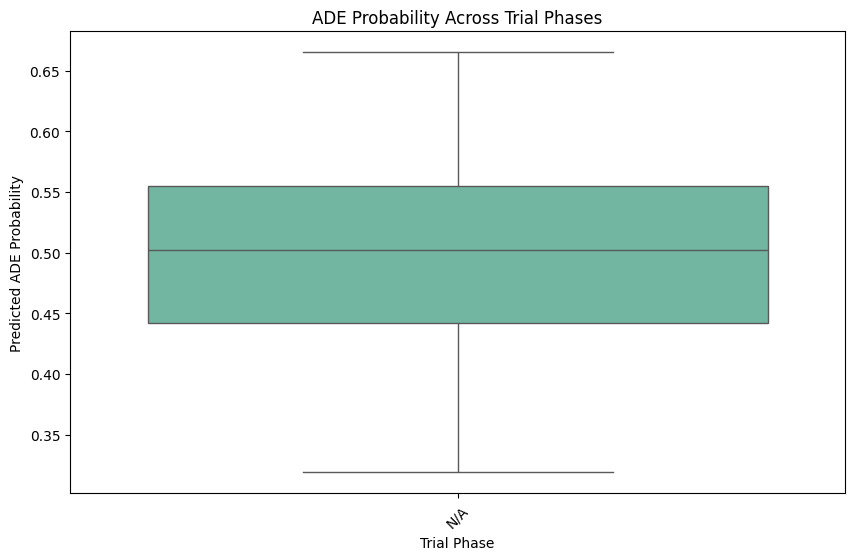

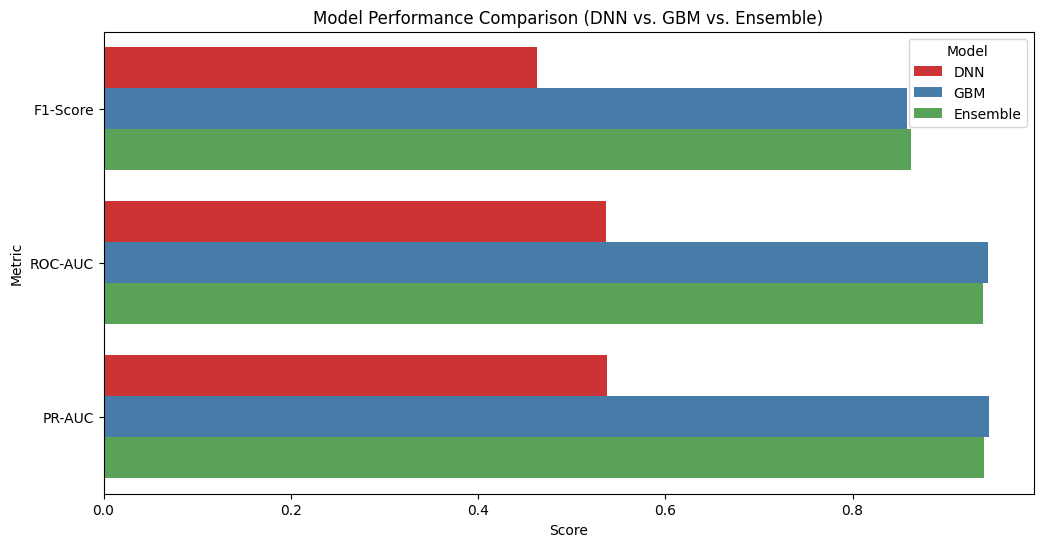

C:\Users\niraj\AppData\Local\Temp\ipykernel_15644\623909961.py:76: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(x='Sex_Label', y='ADE_Probability', hue='Age_Group', data=data_df, palette='Pastel1')
C:\Users\niraj\AppData\Local\Temp\ipykernel_15644\623909961.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Age Group")


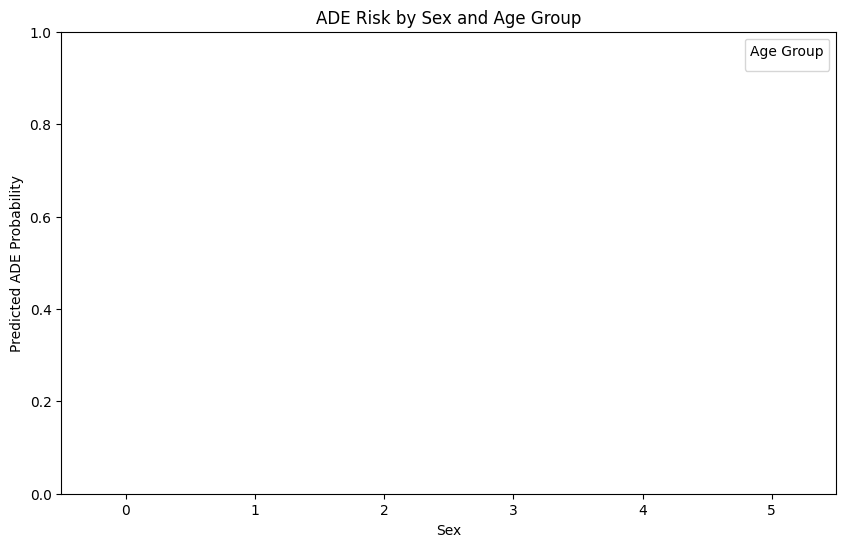

C:\Users\niraj\AppData\Local\Temp\ipykernel_15644\623909961.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Phase', y='Dosage', data=data_df, palette='Set3')


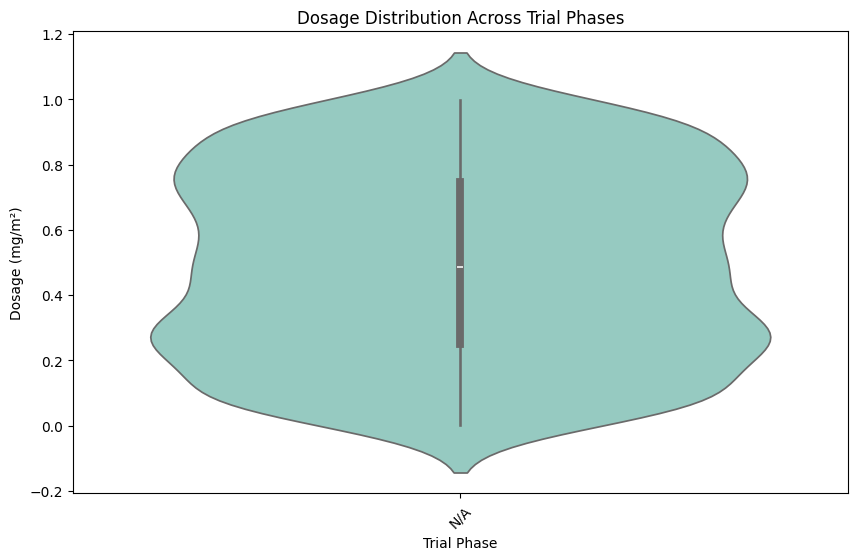

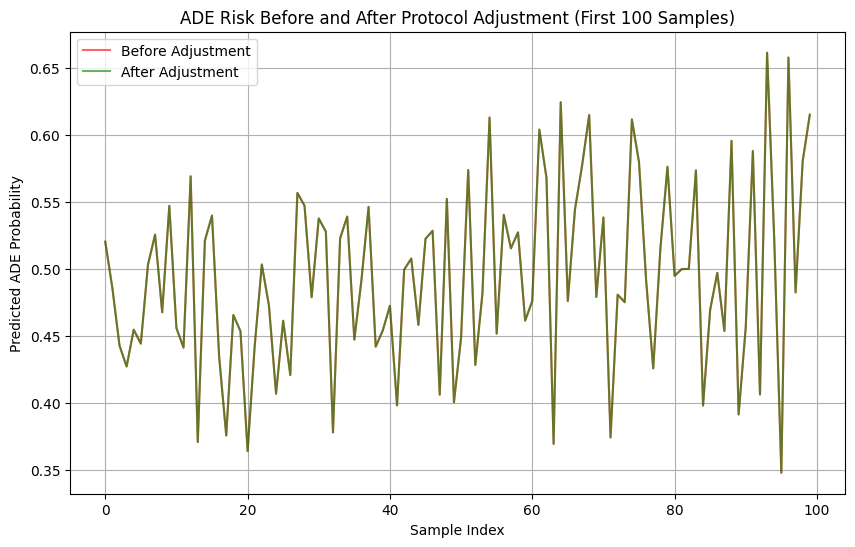

2025-06-06 15:52:37,181 - INFO - Generating comparison visualizations...
2025-06-06 15:52:37,182 - INFO - Comparison visualizations complete.


In [14]:
# Install required packages (if not already installed)
!pip install pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Step 5: Additional Comparison Visualizations
# 5.1: ADE Probability Across Trial Phases (Box Plot)
# Create a DataFrame for easier manipulation
data_df = pd.DataFrame({
    'ADE_Probability': y_pred,
    'Phase': [entry['phase'] for entry in metadata],
    'Sex': numerical_features[:, 1],  # 0 for female, 1 for male
    'Age': numerical_features[:, 0],
    'Dosage': numerical_features[:, 2]
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Phase', y='ADE_Probability', data=data_df, palette='Set2')
plt.title("ADE Probability Across Trial Phases")
plt.xlabel("Trial Phase")
plt.ylabel("Predicted ADE Probability")
plt.xticks(rotation=45)
plt.show()

# 5.2: Model Performance (DNN vs. GBM vs. Ensemble) (Bar Plot)
# Compute metrics for each model
y_pred_binary_dnn = (y_dnn > 0.5).astype(int)
y_pred_binary_gbm = (y_gbm > 0.5).astype(int)
y_pred_binary_ensemble = (y_pred > 0.5).astype(int)

f1_dnn = f1_score(labels, y_pred_binary_dnn)
f1_gbm = f1_score(labels, y_pred_binary_gbm)
f1_ensemble = f1_score(labels, y_pred_binary_ensemble)

roc_auc_dnn = roc_auc_score(labels, y_dnn)
roc_auc_gbm = roc_auc_score(labels, y_gbm)
roc_auc_ensemble = roc_auc_score(labels, y_pred)

precision_dnn, recall_dnn, _ = precision_recall_curve(labels, y_dnn)
precision_gbm, recall_gbm, _ = precision_recall_curve(labels, y_gbm)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(labels, y_pred)

pr_auc_dnn = auc(recall_dnn, precision_dnn)
pr_auc_gbm = auc(recall_gbm, precision_gbm)
pr_auc_ensemble = auc(recall_ensemble, precision_ensemble)

# Create a DataFrame for plotting
metrics_df = pd.DataFrame({
    'Model': ['DNN', 'DNN', 'DNN', 'GBM', 'GBM', 'GBM', 'Ensemble', 'Ensemble', 'Ensemble'],
    'Metric': ['F1-Score', 'ROC-AUC', 'PR-AUC'] * 3,
    'Value': [f1_dnn, roc_auc_dnn, pr_auc_dnn, f1_gbm, roc_auc_gbm, pr_auc_gbm, f1_ensemble, roc_auc_ensemble, pr_auc_ensemble]
})

plt.figure(figsize=(12, 6))
sns.barplot(x='Value', y='Metric', hue='Model', data=metrics_df, palette='Set1')
plt.title("Model Performance Comparison (DNN vs. GBM vs. Ensemble)")
plt.xlabel("Score")
plt.ylabel("Metric")
plt.legend(title="Model")
plt.show()

# 5.3: ADE Risk by Sex and Age Group (Grouped Bar Plot)
# Categorize age into groups
data_df['Age_Group'] = pd.cut(data_df['Age'], bins=[18, 65, 100], labels=['Adult (18-65)', 'Older Adult (65-100)'])
data_df['Sex_Label'] = data_df['Sex'].map({0: 'Female', 1: 'Male'})

plt.figure(figsize=(10, 6))
sns.barplot(x='Sex_Label', y='ADE_Probability', hue='Age_Group', data=data_df, palette='Pastel1')
plt.title("ADE Risk by Sex and Age Group")
plt.xlabel("Sex")
plt.ylabel("Predicted ADE Probability")
plt.legend(title="Age Group")
plt.show()

# 5.4: Dosage Distribution Across Phases (Violin Plot)
plt.figure(figsize=(10, 6))
sns.violinplot(x='Phase', y='Dosage', data=data_df, palette='Set3')
plt.title("Dosage Distribution Across Trial Phases")
plt.xlabel("Trial Phase")
plt.ylabel("Dosage (mg/m²)")
plt.xticks(rotation=45)
plt.show()

# 5.5: Protocol Adjustment Impact on ADE Risk (Line Plot with Before/After)
# Simulate ADE probabilities before and after protocol adjustment
ade_before = y_pred.copy()  # Before adjustment
protocol_values = []
ade_after = []
env = TrialEnv()
state, _ = env.reset()
initial_protocol = env.protocol
for step in range(20):
    action, _ = rl_model.predict(state)
    state, reward, done, truncated, _ = env.step(action)
    protocol_values.append(env.protocol)
    if done or truncated:
        state, _ = env.reset()

# Simulate a simple adjustment effect: reduce ADE probability based on protocol change
adjustment_factor = (env.protocol - initial_protocol) * 0.05  # Hypothetical reduction
ade_after = np.maximum(ade_before - adjustment_factor, 0)  # Ensure non-negative probabilities

# Plot comparison
plt.figure(figsize=(10, 6))
plt.plot(range(len(ade_before[:100])), ade_before[:100], label='Before Adjustment', color='red', alpha=0.6)
plt.plot(range(len(ade_after[:100])), ade_after[:100], label='After Adjustment', color='green', alpha=0.6)
plt.title("ADE Risk Before and After Protocol Adjustment (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Predicted ADE Probability")
plt.legend()
plt.grid(True)
plt.show()

# Main Workflow
def main():
    logging.info("Generating comparison visualizations...")

    # Visualizations are already included above

    logging.info("Comparison visualizations complete.")

if __name__ == "__main__":
    main()